In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns

In [2]:
df_train = pd.read_csv('train.csv.zip', parse_dates=[0])
df_spray = pd.read_csv('spray.csv.zip', parse_dates=[0])
df_weather = pd.read_csv('weather.csv.zip', parse_dates=[1])

In [3]:
df_spray.drop('Time', axis=1, inplace=True)


In [4]:
df_spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [5]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [7]:
# Adding minimum temperature feature

df_weather = pd.read_csv('weather.csv.zip', parse_dates=[1])
df_temperature = df_weather[['Station', 'Date', 'Tmin']][df_weather['Station'] == 1]
df_temperature.drop('Station', axis=1, inplace=True)
df_train = pd.merge(df_train,df_temperature, on='Date')

In [8]:
# One-hot encoded species

df_train = pd.get_dummies(df_train, columns=['Species'])

# Makes no difference...

In [9]:
# Adding month and day

df_train['month'] = df_train['Date'].map(lambda x: x.month)
df_train['day_of_month'] = df_train['Date'].map(lambda x: x.day)
# df_train['month_day'] = df_train['Date'].dt.strftime('%m-%d')

In [10]:
# DBSCAN

labels = DBSCAN(eps=0.02).fit_predict(df_train[['Latitude', 'Longitude']])
df_train['area'] = labels

In [11]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [12]:
# Spray times

len(df_train)

10506

/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


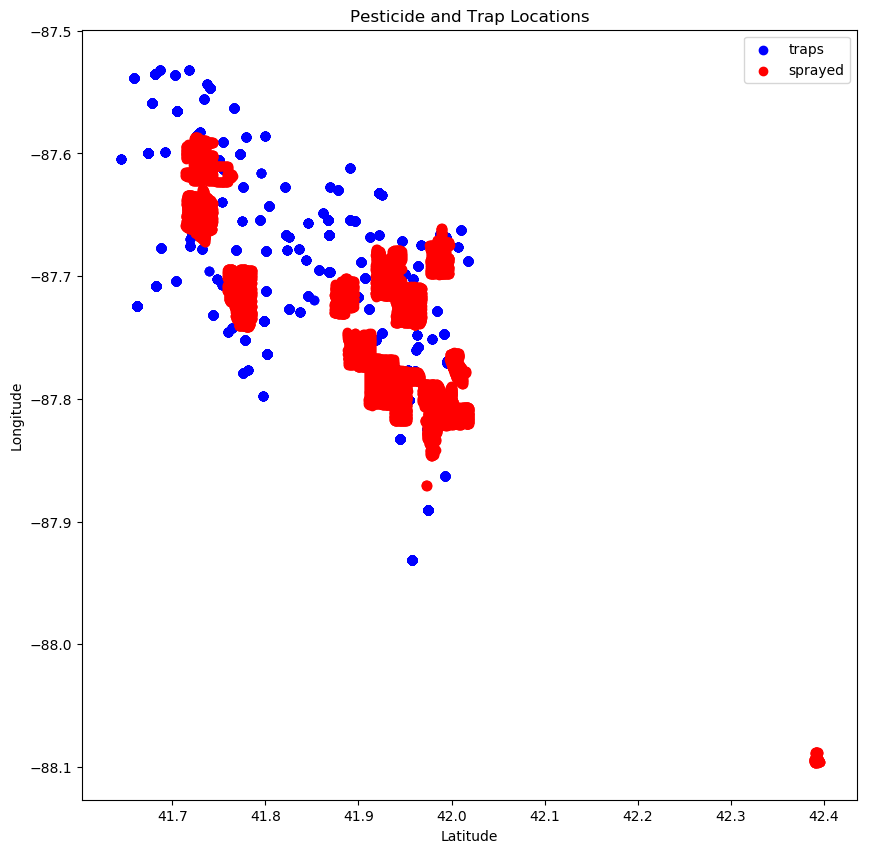

In [13]:
sns.reset_orig()
plt.figure(figsize=(10,10))
plt.scatter(df_train['Latitude'], df_train['Longitude'], c='b', alpha=1, label='traps')
plt.scatter(df_spray['Latitude'], df_spray['Longitude'], c='r', alpha=1, label='sprayed')
plt.legend()
plt.title('Pesticide and Trap Locations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show();

# Running the model

In [14]:
y = df_train['WnvPresent'].copy()
X = df_train.drop('WnvPresent', axis=1).copy()
X.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet','Latitude','Longitude'], axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.745244614822928

In [16]:
# Generating feature importance table
pd.DataFrame(np.vstack((X_test.columns, clf.feature_importances_)).T, columns=['Feature','Importance']).sort_values(by='Importance', ascending=False)

,Feature,Importance
1,NumMosquitos,0.365801
12,area,0.23072
11,day_of_month,0.136589
2,Tmin,0.112557
10,month,0.0584647
0,AddressAccuracy,0.0572921
4,Species_CULEX PIPIENS,0.0168285
6,Species_CULEX RESTUANS,0.011032
5,Species_CULEX PIPIENS/RESTUANS,0.0101673
9,Species_CULEX TERRITANS,0.000447886
